# Deep Learning - Fast AI

Este notebook apresenta um conjunto de demonstrações de Deep Learning utilizando o pacote `fastai`, um pacote construído em cima do `pytorch`. O pacote [fast.ai](https://course.fast.ai/) é utilizado em cursos, pesquisas e no mercado de trabalho - além disso, ele mantém os principais pacotes de Aprendizado Profundo ( _i.e.,_ Deep Learning) e Aprendizado de Máquina ( _i.e.,_ Machine Learning) utilizados atualmente. Neste notebook vamos ver como (1) classificar imagens utilizando a [ResNet34](https://www.kaggle.com/pytorch/resnet34) (da Microsoft) para identificar cachorros e gatos a partir de fotos; (2) utilizar a [AWD-LSTM](https://arxiv.org/abs/1803.08240) (do Salesforce) para análise de sentimento por meio de textos; e, por fim (3) uma classificação de salário de pessoas utilizando uma rede neural profunda, criada do zero.

> Conteúdo voltado para nível intermediário de Aprendizado de Máquina e Ciência de Dados!

<a id="top"></a>
## Conteúdo

> **Nota.** Alguns códigos foram ocultados a fim de facilitar a leitura e dar destaque para os conteúdos mais importantes.

O notebook está organizado como segue:

- [Classificação de Images](#classification) - Classificar fotos de gatos e cachorros.
- [Análise de Sentimento](#sentiment_analysis) - Análise de texto, indicando positividade ou negatividade.
- [Classificação de Salário](#classification2) - Predizer o salário de acordo com as características da pessoa.

-----

<a id="classification"></a>
# Classificação de Images

Classificação utilizando a [ResNet34](https://www.kaggle.com/pytorch/resnet34) (da Microsoft) para identificar cachorros e gatos a partir de fotos. [História](https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8) - A ResNet foi vencedora do ILSVRC 2015 em classificação, detecção e localização de imagens, bem como Vencedor do MS COCO 2015, em detecção e segmentação de imagens. O [artigo](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) da ResNet, publicado na CVPR em 2016, possui mais de 19.000 citações.

Nesta seção, utilizamos a rede ResNet34 treinada na ImageNet, um dataset de mais de 15 milões de imagens de alta-resolução rotuladas em aproximadamente 22,000 classes. Esta rede será adaptada para o nosso problema, ou seja, será realizado um [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) - para que a rede aprenda sobre o nosso problema em questão.

[Voltar para o Topo](#top)

In [1]:
from fastai.vision.all import *

### Dados

Fotos dos gatos e cachorros, bem como uma função para identificar suas respectivas classes.

In [2]:
def is_cat(x): return x[0].isupper()

path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

In [3]:
print(f'Número de imagens: {dls.n}')

Número de imagens: 5912


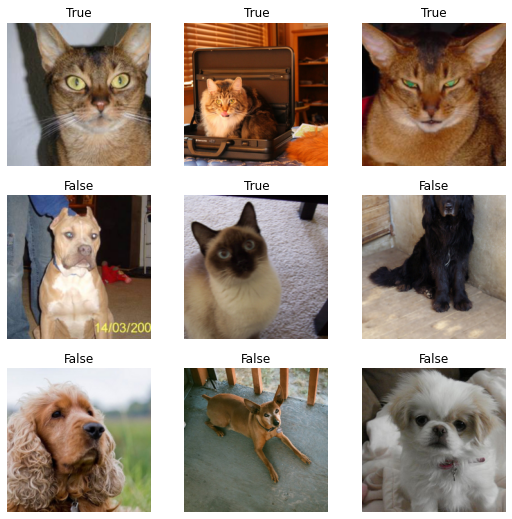

In [4]:
dls.show_batch()

### Aprendizado

Treinamento e avaliação do modelo.

In [5]:
learn1 = cnn_learner(dls, resnet34, metrics=error_rate)
learn1.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.141523,0.028455,0.009472,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.049345,0.034125,0.008119,00:51
1,0.038485,0.039356,0.008796,00:51
2,0.043063,0.021242,0.006089,00:50
3,0.031812,0.013846,0.003383,00:50
4,0.012471,0.012460,0.002706,00:50


### Teste

Testando empiricamente a classificação de uma foto.

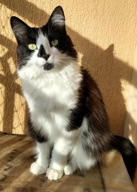

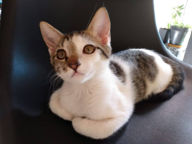

In [6]:
img = PILImage.create('../input/boshchewie/IMG-20200623-WA0028.jpg')
img2 = PILImage.create('../input/boshchewie/IMG-20200715-WA0005.jpg')

display(img.to_thumb(192))
display(img2.to_thumb(192))

In [7]:
is_cat,_,probs = learn1.predict(img)

print(f"É um gato? {is_cat}.")
print(f"Probabilidade de ser um gato : {probs[1].item():.6f}")

É um gato? True.
Probabilidade de ser um gato : 0.982697


-----

<a id="sentiment_analysis"></a>
# Análise de Sentimento

Nesta tarefa utilizaremos a red [AWD-LSTM](https://arxiv.org/abs/1803.08240) (do Salesforce) para análise de sentimento por meio de textos. AWD-LSTM  é uma adaptação recente do [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) que mostra melhorias substanciais no estado da arte para modelagem de linguagem, usando técnicas muito úteis em uma série de problemas de [NLP](https://en.wikipedia.org/wiki/Natural_language_processing).

[Voltar para o Topo](#top)

In [8]:
from fastai.text.all import *

### Dados

Carregando um conjunto de avaliações do IMDb, e seus sentimentos.

In [9]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [10]:
print(f'Número de reviews: {dls.n}')

Número de reviews: 25000


In [11]:
dls.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos * ! ! - xxup spoilers - ! ! * \n\n xxmaj before i begin this , let me say that i have had both the advantages of seeing this movie on the big screen and of having seen the "" authorized xxmaj version "" of this movie , remade by xxmaj stephen xxmaj king , himself , in 1997 . \n\n xxmaj both advantages made me appreciate this version of "" the xxmaj shining , "" all the more . \n\n xxmaj also , let me say that xxmaj i 've read xxmaj mr . xxmaj king 's book , "" the xxmaj shining "" on many occasions over the years , and while i love the book and am a huge fan of his work , xxmaj stanley xxmaj kubrick 's retelling of this story is far more compelling … and xxup scary . \n\n xxmaj kubrick",pos
2,"xxbos i thought that xxup rotj was clearly the best out of the three xxmaj star xxmaj wars movies . i find it surprising that xxup rotj is considered the weakest installment in the xxmaj trilogy by many who have voted . xxmaj to me it seemed like xxup rotj was the best because it had the most profound plot , the most suspense , surprises , most xxunk the ending ) and definitely the most episodic movie . i personally like the xxmaj empire xxmaj strikes xxmaj back a lot also but i think it is slightly less good than than xxup rotj since it was slower - moving , was not as episodic , and i just did not feel as much suspense or emotion as i did with the third movie . \n\n xxmaj it also seems like to me that after reading these surprising reviews that",pos
3,"xxbos xxmaj the premise of this movie has been tickling my imagination for quite some time now . xxmaj we 've all heard or read about it in some kind of con - text . xxmaj what would you do if you were all alone in the world ? xxmaj what would you do if the entire world suddenly disappeared in front of your eyes ? xxmaj in fact , the last part is actually what happens to xxmaj dave and xxmaj andrew , two room - mates living in a run - down house in the middle of a freeway system . xxmaj andrew is a nervous wreck to say the least and xxmaj dave is considered being one of the biggest losers of society . xxmaj that alone is the main reason to why these two guys get so well along , because they simply only have each",pos
4,"xxbos xxmaj director xxmaj douglas xxmaj sirk once said ` there 's a very short distance between high art and trash , and trash that contains craziness is by this very quality nearer to art ' . xxmaj this statement defines his cinema perfectly , a very unique body of work that includes classic stage adaptations , adventure and war films , westerns and of course , his famous melodramas . \n\n xxmaj sirk 's melodramas were , as the very word signifies , dramas with music . xxmaj the music sets the tone for his masterful style , and every stroke of his brush ( sirk was also a painter ) leaves a powerful image on the screen - turned - canvas . xxmaj but this ai n't life but its representation , an imitation of life . xxmaj sirk never tried to show reality , on the contrary",pos
5,"xxbos xxmaj now that xxmaj xxunk ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can

### Aprendizado

Treinamento e avaliação do modelo.

In [12]:
learn2 = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn2.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.460219,0.392861,0.824080,02:21


epoch,train_loss,valid_loss,accuracy,time
0,0.298758,0.272166,0.887640,04:18
1,0.231941,0.205189,0.919680,04:18
2,0.173257,0.191339,0.928400,04:18


### Teste

Testando empiricamente a análise de sentimento de um texto.

In [13]:
sentiment,_,probs = learn2.predict("I really liked that movie!")

print(f"Qual o sentimento? {sentiment}.")
print(f"Probabilidades : {probs[1].item():.6f}")

Qual o sentimento? pos.
Probabilidades : 0.999191


-----

<a id="classification2"></a>
# Classificação de Salário

Nesta tarefa vamos trabalhar com dados tabulares, contendo valores numéricos e categóricos. Além disso, vamos criar nossa própria rede neural e treina-la a partir dos dados. Utilizaremos a rede neural "padrão" sugerida para trabalhar com dados tabulares `tabular_learner`, com duas camadas escondidades de, respectivamente, \[200,100\] nós.

[Voltar para o Topo](#top)

In [14]:
from fastai.tabular.all import *

### Dados

Um conjunto de dados "tradicional", contendo valores categóricos e numéricos - além da classe a ser predita (salário).

In [15]:
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [16]:
print(f'Número de linhas: {dls.n}')

Número de linhas: 26049


In [17]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Never-married,Sales,Own-child,White,False,31.000000,114690.998413,9.0,<50k
1,Private,Assoc-voc,Married-civ-spouse,Prof-specialty,Husband,Black,False,42.000000,240255.001004,11.0,>=50k
2,Private,11th,Never-married,Other-service,Other-relative,Black,False,18.000000,335665.002527,7.0,<50k
3,Private,Some-college,Never-married,Adm-clerical,Own-child,Black,False,27.000000,72208.001731,10.0,<50k
4,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,White,False,35.000000,165766.999850,10.0,<50k
5,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,Asian-Pac-Islander,False,33.000000,112847.001689,9.0,<50k
6,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,50.000000,293195.997146,9.0,>=50k
7,Private,1st-4th,Married-civ-spouse,Transport-moving,Husband,Black,False,73.999999,91488.001631,2.0,<50k
8,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,False,40.000000,160369.000017,14.0,>=50k
9,Private,HS-grad,Divorced,Handlers-cleaners,Own-child,White,False,35.000000,182074.000375,9.0,<50k


### Aprendizado

Treinamento e avaliação do modelo.   
Neste exemplo, durante o aprendizado já é nos retornado a métrica de desempenho.

In [18]:
learn3 = tabular_learner(dls, metrics=accuracy)
learn3.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.366674,0.371304,0.825706,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.363770,0.352973,0.836456,00:06
1,0.355418,0.355577,0.833231,00:05
2,0.354406,0.350094,0.837684,00:06
3,0.344029,0.349656,0.839220,00:05
4,0.330562,0.349349,0.837838,00:05


### Teste

Apresentando os resultados de algumas classificações.

In [19]:
learn3.show_results()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,16.0,1.0,5.0,2.0,5.0,1.0,0.913231,1.194808,-0.034612,0.0,0.0
1,5.0,9.0,3.0,13.0,1.0,5.0,1.0,-0.041091,1.163711,0.355692,1.0,1.0
2,5.0,16.0,5.0,8.0,4.0,5.0,1.0,-1.362460,0.690630,-0.034612,0.0,0.0
3,7.0,15.0,1.0,11.0,5.0,5.0,1.0,0.252546,-1.517018,1.916910,1.0,1.0
4,5.0,12.0,5.0,9.0,2.0,5.0,1.0,-0.554957,0.076944,-0.424916,0.0,0.0
5,5.0,3.0,5.0,13.0,4.0,5.0,1.0,-1.509279,-1.445501,-0.815221,0.0,0.0
6,5.0,16.0,3.0,4.0,1.0,5.0,1.0,1.280278,-1.487454,-0.034612,1.0,0.0
7,5.0,10.0,5.0,14.0,2.0,3.0,1.0,-0.848594,2.874738,1.136301,0.0,0.0
8,5.0,12.0,5.0,13.0,5.0,5.0,1.0,-1.215641,1.460723,-0.424916,0.0,0.0
